In [9]:
import json
import math
import os

import cv2
from PIL import Image
import numpy as np
from keras import layers
from keras.applications import ResNet50,MobileNet, DenseNet201, InceptionV3, NASNetLarge, InceptionResNetV2, NASNetMobile
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
from tqdm import tqdm
import tensorflow as tf
from keras import backend as K
import gc

from functools import partial
from sklearn import metrics
from collections import Counter
import json
import itertools


%matplotlib inline

In [37]:
cd "C:/Users/elfak/OneDrive/Dataset"

C:\Users\elfak\OneDrive\Dataset


In [35]:
cd ..

C:\Users\elfak


In [36]:
train_data_dir = 'data/train'
validation_data_dir = 'data/val'
test_data_dir = 'data/test'

In [51]:
def Dataset_loader(DIR, RESIZE, sigmaX=10):
    IMG = []
    read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))
    for IMAGE_NAME in tqdm(os.listdir(DIR)):
        PATH = os.path.join(DIR,IMAGE_NAME)
        _, ftype = os.path.splitext(PATH)
        if ftype == ".png":
            img = read(PATH)
           
            img = cv2.resize(img, (RESIZE,RESIZE))
           
            IMG.append(np.array(img))
    return IMG

benign_train = np.array(Dataset_loader('data/train/Benign',224))
malign_train = np.array(Dataset_loader('data/train/Malignant',224))
benign_test = np.array(Dataset_loader('data/test/Benign',224))
malign_test = np.array(Dataset_loader('data/test/Malignant',224))

100%|██████████████████████████████████████████████████████████████████████████████| 300/300 [00:00<00:00, 1371.86it/s]


In [52]:

benign_train_label = np.zeros(len(benign_train))
malign_train_label = np.ones(len(malign_train))
benign_test_label = np.zeros(len(benign_test))
malign_test_label = np.ones(len(malign_test))

X_train = np.concatenate((benign_train, malign_train), axis = 0)
Y_train = np.concatenate((benign_train_label, malign_train_label), axis = 0)
X_test = np.concatenate((benign_test, malign_test), axis = 0)
Y_test = np.concatenate((benign_test_label, malign_test_label), axis = 0)

s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
Y_train = Y_train[s]

s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
Y_test = Y_test[s]

Y_train = to_categorical(Y_train, num_classes= 2)
Y_test = to_categorical(Y_test, num_classes= 2)

In [53]:

x_train, x_val, y_train, y_val = train_test_split(
    X_train, Y_train, 
    test_size=0.2, 
    random_state=11
)

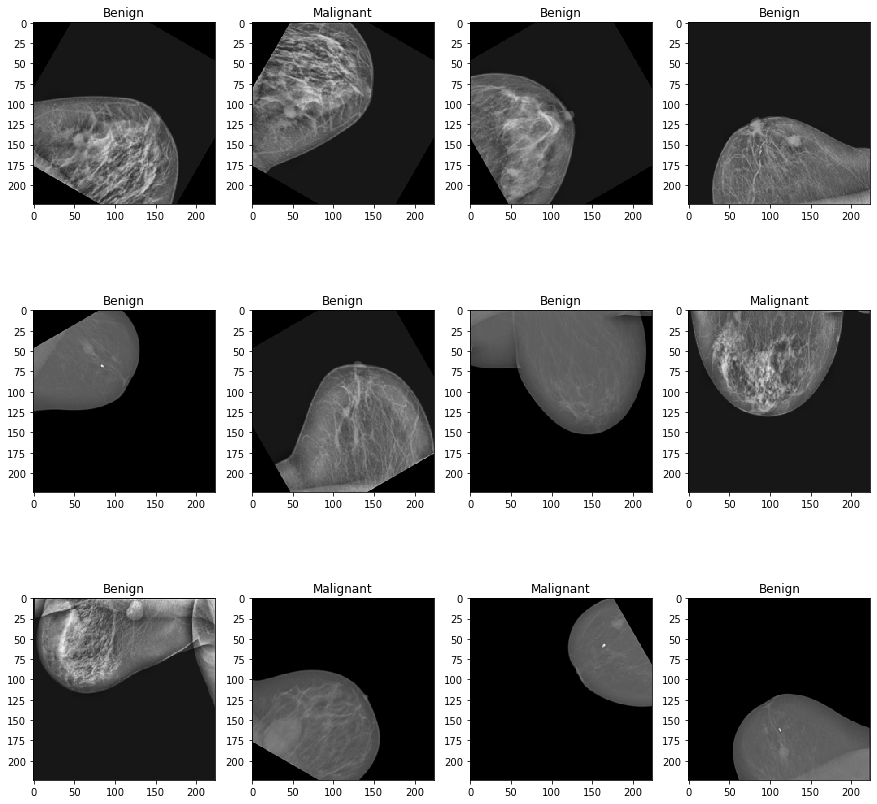

In [54]:
w=60
h=40
fig=plt.figure(figsize=(15, 15))
columns = 4
rows = 3

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if np.argmax(Y_train[i]) == 0:
        ax.title.set_text('Benign')
    else:
        ax.title.set_text('Malignant')
    plt.imshow(x_train[i], interpolation='nearest')
plt.show()

In [55]:
BATCH_SIZE = 16

# Using original generator
train_generator = ImageDataGenerator(
        zoom_range=2,  
        rotation_range = 90,
        horizontal_flip=True,  
        vertical_flip=True,  
    )

In [56]:
def build_model(backbone, lr=1e-4):
    model = Sequential()
    model.add(backbone)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(2, activation='softmax'))
    
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(lr=lr),
        metrics=['accuracy']
    )
    
    return model



In [57]:
K.clear_session()
gc.collect()

resnet = DenseNet201(
    weights='imagenet',
    include_top=False,
    input_shape=(224,224,3)
)


model = build_model(resnet ,lr = 1e-4)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Functional)     (None, 7, 7, 1920)        18321984  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1920)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1920)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1920)              7680      
_________________________________________________________________
dense (Dense)                (None, 2)                 3842      
Total params: 18,333,506
Trainable params: 18,100,610
Non-trainable params: 232,896
_________________________________________________________________


In [58]:
learn_control = ReduceLROnPlateau(monitor='val_accuracy', patience=5,
                                  verbose=1,factor=0.2, min_lr=1e-7)

# Checkpoint
filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

In [59]:
history = model.fit_generator(
    train_generator.flow(x_train, y_train, batch_size=BATCH_SIZE),
    steps_per_epoch=x_train.shape[0] // BATCH_SIZE,
    epochs=20,
    validation_data=(x_val, y_val),
    callbacks=[learn_control, checkpoint]
)

Epoch 1/20
90/90 [==============================] - ETA: 0s - loss: 0.8513 - accuracy: 0.5396 
Epoch 00001: val_accuracy improved from -inf to 0.53611, saving model to weights.best.hdf5
90/90 [==============================] - 1347s 15s/step - loss: 0.8513 - accuracy: 0.5396 - val_loss: 1.0383 - val_accuracy: 0.5361
Epoch 2/20
90/90 [==============================] - ETA: 0s - loss: 0.8387 - accuracy: 0.5444 
Epoch 00002: val_accuracy improved from 0.53611 to 0.58333, saving model to weights.best.hdf5
90/90 [==============================] - 1099s 12s/step - loss: 0.8387 - accuracy: 0.5444 - val_loss: 0.8530 - val_accuracy: 0.5833
Epoch 3/20
90/90 [==============================] - ETA: 0s - loss: 0.7833 - accuracy: 0.5750 
Epoch 00003: val_accuracy improved from 0.58333 to 0.61944, saving model to weights.best.hdf5
90/90 [==============================] - 987s 11s/step - loss: 0.7833 - accuracy: 0.5750 - val_loss: 0.8183 - val_accuracy: 0.6194
Epoch 4/20
90/90 [=======================

In [60]:
with open('history.json', 'w') as f:
    json.dump(str(history.history), f)

<AxesSubplot:>

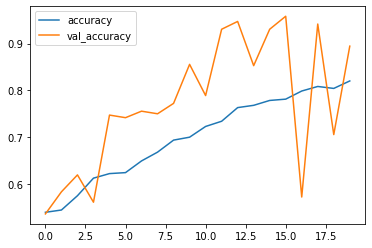

In [61]:

history_df = pd.DataFrame(history.history)
history_df[['accuracy', 'val_accuracy']].plot()

<AxesSubplot:>

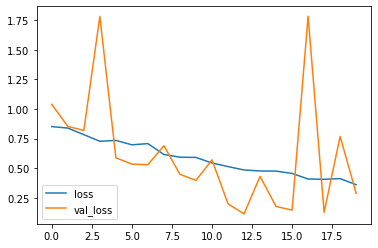

In [62]:
history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()

In [70]:
model.load_weights("weights.best.hdf5")

Y_val_pred = model.predict(x_val)

accuracy_score(np.argmax(y_val, axis=1), np.argmax(Y_val_pred, axis=1))

Y_pred = model.predict(X_test)

tta_steps = 10
predictions = []

for i in tqdm(range(tta_steps)):
    preds = model.predict_generator(train_generator.flow(X_test, batch_size=BATCH_SIZE, shuffle=False),
                                    steps = len(X_test)//BATCH_SIZE)
    
    predictions.append(preds)
    gc.collect()
    
Y_pred_tta = np.mean(predictions, axis=0)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [11:47<00:00, 70.80s/it]


Confusion matrix, without normalization
[[287  13]
 [ 39 261]]


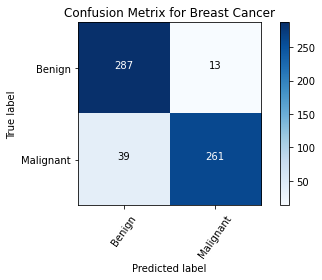

In [65]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=55)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

cm = confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1))

cm_plot_label =['Benign', 'Malignant']
plot_confusion_matrix(cm, cm_plot_label, title ='Confusion Metrix for Breast Cancer')

In [69]:
from sklearn.metrics import classification_report
print(classification_report(np.argmax(Y_test,axis=1),np.argmax(Y_pred,axis=1), target_names=cm_plot_label))

              precision    recall  f1-score   support

      Benign       0.88      0.96      0.92       300
   Malignant       0.95      0.87      0.91       300

    accuracy                           0.91       600
   macro avg       0.92      0.91      0.91       600
weighted avg       0.92      0.91      0.91       600

